In [200]:
import sys
sys.path.append('../')
from os.path import abspath
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.io import savemat
import pickle
import math

#import character_mod

from generate_mod import sample_clutter
import io_mod, generate_mod, Clutter_mod, utils_mod
from utils_mod import shlex_cmd, DIGITS

%load_ext autoreload
%autoreload 2

In [163]:
#FILENAME = "/Volumes/RCONCI/2 digits fixed offset/"
FILENAME = "/Users/riccardoconci/Desktop/code/Zuckerman_Project/Dataset"
#FILENAME = "/Volumes/RCONCI/2_digits_fixed_2"
#FILENAME = "/Volumes/RCONCI/2_dig_fixed_random_bw"
import os
os.chdir(FILENAME)

In [283]:
n_samples = 20
clutter_list = []
for i in range(n_samples):
    clutter_list += [sample_clutter(image_size = (256,256),
                                    fontsize = 140,
                                    font_set=['helvetica-bold'], 
                                    n_letters=2,
                                   linewidth=5, 
                                   face_colour_set =[(0, 0, 0, 1.0),(255,255,255, 1.0)], 
                                   edge_colour_set= [(255,255,255, 1.0), (0, 0, 0, 1.0)],
                                   offset_cov = ((0,0),(0,0)),
                                   offset_mean = [(-0.18,-0.18),(0.18,0.18)])]

In [284]:
256/2

128.0

In [285]:
clutter_list = io_mod.name_files('{}/digts'.format(FILENAME), clutter_list=clutter_list)
io_mod.save_image_set(clutter_list, '{}/digts/digts.csv'.format(FILENAME))
#/Volumes/RCONCI/2 digits colours

#loaded_clutter_list = io_mod.read_image_set('/Volumes/RCONCI/2 digits fixed offset/test/test.csv')

Overwriting /Users/riccardoconci/Desktop/code/Zuckerman_Project/Dataset/digts/digts.csv


In [286]:

train_size = int(n_samples*0.98)
test_size = n_samples-train_size
print(train_size,test_size)

19 1


In [287]:
fname_list = []
for i, cl in enumerate(clutter_list):
    if i < train_size:
        cl.render_occlusion(fname="{}/digts/train/orig/orig_{}".format(FILENAME,i)) #/Volumes/RCONCI/2 digits colours/
        cl.render_occlusion(fname="{}/digts/train/inverse/inverse_{}".format(FILENAME,i), inverse=True)
        fname_list.append("{}/digts/train/orig/orig_{}".format(FILENAME, i))
        fname_list.append("{}/digts/train/inverse/inverse_{}".format(FILENAME,i))
    elif i >= train_size:
        cl.render_occlusion(fname="{}/digts/test/orig/orig_{}".format(FILENAME,i)) #/Volumes/RCONCI/2 digits colours/
        cl.render_occlusion(fname="{}/digts/test/inverse/inverse_{}".format(FILENAME,i), inverse=True)
        fname_list.append("{}/digts/test/orig/orig_{}".format(FILENAME, i))
        fname_list.append("{}/digts/test/inverse/inverse_{}".format(FILENAME,i))
        

In [249]:
import pandas as pd 
file = '/Users/riccardoconci/Desktop/2_dig_fixed_random_bw/digts/digts.csv'
data = pd.read_csv(file, header=None)
train_data = data.iloc[:9800, :]
test_data = data.iloc[9800:, :]

digt_list_train = train_data.iloc[:, [5,21]].values.astype(int)
cols_train = train_data.iloc[:, [12, 32]].values/255
cols_train = cols_train.astype(int)
x_back_train = train_data.iloc[:, 6].values.astype(float)
y_back_train = train_data.iloc[:, 7].values.astype(float)
x_front_train = train_data.iloc[:, 22].values.astype(float)
y_front_train = train_data.iloc[:, 23].values.astype(float)
distance_train = np.sqrt((x_front_train - x_back_train)**2 + (y_front_train - y_back_train)**2)

digt_list_test = test_data.iloc[:, [5,21]].values.astype(int)
cols_test = test_data.iloc[:, [12, 32]].values/255
cols_test = cols_test.astype(int)
x_back_test = test_data.iloc[:, 6].values.astype(float)
y_back_test= test_data.iloc[:, 7].values.astype(float)
x_front_test = test_data.iloc[:, 22].values.astype(float)
y_front_test = test_data.iloc[:, 23].values.astype(float)
distance_test = np.sqrt((x_front_test - x_back_test)**2 + (y_front_test - y_back_test)**2)


In [250]:
cols_train

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [253]:
new_train_df = np.zeros((train_data.shape[0], 2))
#new_test_df = np.zeros((test_data.shape[0], 2))

for i in range(train_data.shape[0]):
    new_train_df[i,cols_train[i,0]] = digt_list_train[i,0]
    new_train_df[i,cols_train[i,1]] = digt_list_train[i,1]

for i in range(test_data.shape[0]):
    new_test_df[i,cols_test[i,0]] = digt_list_test[i,0]
    new_test_df[i,cols_test[i,1]] = digt_list_test[i,1]

black_train = new_train_df[:,0].astype(int)
white_train = new_train_df[:,1].astype(int)
n_values = np.max(black_train) + 1
black_one_hot_train = torch.LongTensor(np.eye(n_values)[black_train])
white_one_hot_train = torch.LongTensor(np.eye(n_values)[white_train])
black_white_one_hot_train = torch.cat((black_one_hot_train,white_one_hot_train), 1)
depth_black_train = torch.LongTensor(cols_train[:,0]).view(9800, -1)
depth_black_white_one_hot_train = torch.cat((depth_black_train, black_white_one_hot_train),1)
depth_black_white_one_hot_train[0:5, :]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [185]:
back = digt_list[:,0]
front =digt_list[:,1]
n_values = np.max(back) + 1
back_one_hot = torch.LongTensor(np.eye(n_values)[back])
front_one_hot = torch.LongTensor(np.eye(n_values)[front])
back_front_one_hot = torch.cat((back_one_hot,front_one_hot),1)
col_back = torch.LongTensor(cols[:,0]).view(10000, -1)
col_back_front_one_hot = torch.cat((col_back, back_front_one_hot),1)
col_back_front_one_hot[0:5, :]

torch.Size([10000, 20])
torch.Size([10000, 1])


tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [187]:
joint_digts_id = front_one_hot + back_one_hot
joint_digts_id[0:5, :]

tensor([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0]])

In [288]:
pickle.dump(fname_list, open( "{}/fname_list.p".format(FILENAME), "wb" ) )
pickle.dump(clutter_list, open( "{}/clutter_list.p".format(FILENAME), "wb" ) )

In [50]:
fname_list = pickle.load(open("{}/fname_list.p".format(FILENAME), "rb" ) )
clutter_list = pickle.load(open("{}/clutter_list.p".format(FILENAME), "rb" ) )

In [51]:
#fname_list = [cl.fname for cl in clutter_list]
images_dict = io_mod.save_images_as_mat(abspath('{}/digts.mat'.format(FILENAME)),
                                        clutter_list, (64,64), fname_list=fname_list, 
                                        overwrite_wdir=True, grayscale=True)

Using /Users/riccardoconci/Desktop/code/Zuckerman_Project/Dataset/temp_workspace as the working directory
Resizing the images
/Users/riccardoconci/Desktop/code/Zuckerman_Project/Dataset/temp_workspace/resized
Generating image arrays
Generating target arrays
Images and target arrays saved to /Users/riccardoconci/Desktop/code/Zuckerman_Project/Dataset/test.mat


In [52]:
pickle.dump(images_dict, open( "{}/images_dict.p".format(FILENAME), "wb" ) )

In [54]:
loaded_image_dict = pickle.load( open( "{}/images_dict.p".format(FILENAME), "rb" ) )

<Figure size 7200x7200 with 0 Axes>

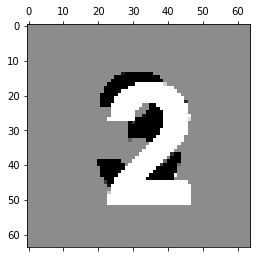

In [60]:
plt.figure(figsize=(100,100))
plt.matshow(images_dict['images'][4,:,:,0], cmap = plt.cm.gray, vmin=0, vmax=60)

In [20]:
fulldatasize = int(images_dict["images"].shape[0]/2)
training_size = int(fulldatasize*0.9)
test_size = int(fulldatasize - training_size)
print(training_size, test_size)

9000 1000


In [46]:
x_train = images_dict["images"][np.arange(0, 2*training_size, step=2),:,:,0]
y_train = images_dict["images"][np.arange(1, 2*training_size, step=2),:,:,0]
x_test = images_dict["images"][np.arange(2*training_size,2*fulldatasize, step=2),:,:,0]
y_test = images_dict["images"][np.arange(2*training_size+1, 2*fulldatasize, step=2),:,:,0]



NameError: name 'images_dict' is not defined

In [45]:
train_object = (x_train, y_train)

NameError: name 'x_train' is not defined

In [24]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9000, 60, 60)
(9000, 60, 60)
(1000, 60, 60)
(1000, 60, 60)


In [25]:
x_train = x_train.astype('float32') / 85.
x_test = x_test.astype('float32') / 85.
x_train = x_train.reshape( (len(x_train), np.prod(x_train.shape[1:]) ) )
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = y_train.astype('float32') / 85.
y_test = y_test.astype('float32') / 85.
y_train = y_train.reshape( (len(y_train), np.prod(y_train.shape[1:]) ) )
y_test = y_test.reshape( (len(y_test), np.prod(y_test.shape[1:]) ) )

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(9000, 3600)
(9000, 3600)
(1000, 3600)
(1000, 3600)


## Basic autoencoder model

In [341]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 60  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(x_train.shape[1],))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(y_train.shape[1], activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [342]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [343]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [344]:
autoencoder.fit(x_train, y_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6935 - val_loss: 0.6929
Epoch 2/50
4000/4000 [==============================] - 3s 848us/step - loss: 0.6926 - val_loss: 0.6922
Epoch 3/50
4000/4000 [==============================] - 4s 923us/step - loss: 0.6916 - val_loss: 0.6907
Epoch 4/50
4000/4000 [==============================] - 3s 839us/step - loss: 0.6894 - val_loss: 0.6872
Epoch 5/50
4000/4000 [==============================] - 3s 820us/step - loss: 0.6844 - val_loss: 0.6801
Epoch 6/50
4000/4000 [==============================] - 3s 837us/step - loss: 0.6753 - val_loss: 0.6690
Epoch 7/50
4000/4000 [==============================] - 3s 836us/step - loss: 0.6639 - val_loss: 0.6580
Epoch 8/50
4000/4000 [==============================] - 3s 824us/step - loss: 0.6549 - val_loss: 0.6513
Epoch 9/50
4000/4000 [==============================] - 3s 824us/step - loss: 0.6501 - val_loss: 0.6483
Epoch 10/50
4000/4

In [32]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

NameError: name 'encoder' is not defined

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(60, 60))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(60, 60))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding a sparsity constraint on the encoded representations
In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [26]:
from keras import regularizers

encoding_dim = 60

input_img = Input(shape=(x_train.shape[1],))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(y_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

/Users/riccardoconci/anaconda3/envs/compneuro/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


NameError: name 'Input' is not defined

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, y_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, y_test))

In [ ]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(60, 60))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(60, 60))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [27]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


input_img = Input(shape=(60, 60, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


Instructions for updating:
Colocations handled automatically by placer.


In [28]:
x_train = images_dict["images"][np.arange(0, 2*training_size, step=2),:,:,0]
y_train = images_dict["images"][np.arange(1, 2*training_size, step=2),:,:,0]
x_test = images_dict["images"][np.arange(2*training_size,2*fulldatasize, step=2),:,:,0]
y_test = images_dict["images"][np.arange(2*training_size+1, 2*fulldatasize, step=2),:,:,0]

x_train = x_train.astype('float32') / 85.
x_test = x_test.astype('float32') / 85.
x_train = np.reshape(x_train, (len(x_train), 60, 60, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 60, 60, 1))  # adapt this if using `channels_first` image data format
y_train = y_train.astype('float32') / 85.
y_test = y_test.astype('float32') / 85.
y_train = np.reshape(y_train, (len(y_train), 60, 60, 1))  # adapt this if using `channels_first` image data format
y_test = np.reshape(y_test, (len(y_test), 60, 60, 1))  # adapt this if using `channels_first` image data format

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)



(9000, 60, 60, 1)
(9000, 60, 60, 1)
(1000, 60, 60, 1)
(1000, 60, 60, 1)


In [31]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 80s 9ms/step - loss: 0.6567 - val_loss: 0.6510
Epoch 2/50
9000/9000 [==============================] - 74s 8ms/step - loss: 0.6493 - val_loss: 0.6467
Epoch 3/50
9000/9000 [==============================] - 77s 9ms/step - loss: 0.6410 - val_loss: 0.6325
Epoch 4/50
9000/9000 [==============================] - 75s 8ms/step - loss: 0.6276 - val_loss: 0.6227
Epoch 5/50
9000/9000 [==============================] - 80s 9ms/step - loss: 0.6208 - val_loss: 0.6181
Epoch 6/50
9000/9000 [==============================] - 79s 9ms/step - loss: 0.6172 - val_loss: 0.6152
Epoch 7/50
9000/9000 [==============================] - 77s 9ms/step - loss: 0.6148 - val_loss: 0.6131
Epoch 8/50
9000/9000 [==============================] - 74s 8ms/step - loss: 0.6131 - val_loss: 0.6116
Epoch 9/50
9000/9000 [==============================] - 76s 8ms/step - loss: 0.6

In [33]:
decoded_imgs = autoencoder.predict(x_test)


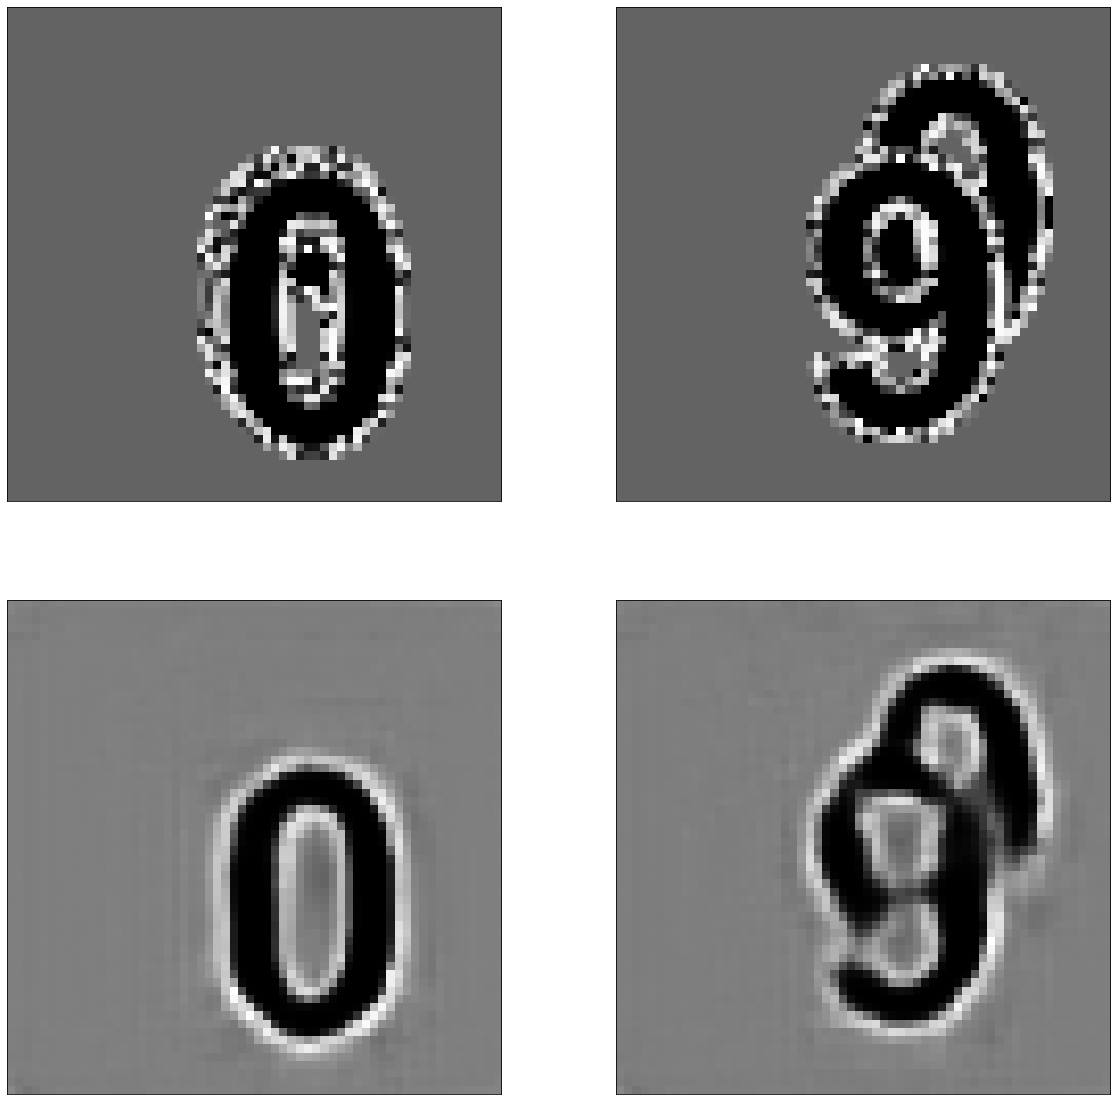

In [47]:

n = 2  # how many digits we will display
plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+15].reshape(60, 60))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+15].reshape(60, 60))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()